# Imports and data download

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
import json
import collections
import random
import numpy as np
import sys

This is the code for assignment 2 by group 2525 in the course ID2223 in 2020.

In this assignment we utilized the following guides and tutorials:

* [The origial paper](https://arxiv.org/pdf/1411.4555.pdf)
* Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, Aurélien Géron, O'Reilly Media, 2019
* [Image captioning with visual attention tutorial](https://www.tensorflow.org/tutorials/text/image_captioning)
* [Create your own image caption generator using keras](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/)

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 7.6MB/s 


In [ ]:
import tensorflow_addons

In [ ]:
USE_DRIVE = False

if USE_DRIVE:
    file_prefix = '/content/drive/MyDrive/scalable-machine-learning-and-deep-learing/'
    from google.colab import drive
    drive.mount('/content/drive')
else:
    file_prefix = '/content/'

Downloading the image and caption data.

We decided to use the MSCOCO dataset as described in the paper.

We followed this guide to get and preprocess dataset: https://www.tensorflow.org/tutorials/text/image_captioning

In [ ]:

annotation_folder = file_prefix + 'captions/annotations/'
if not os.path.exists(annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath(file_prefix + 'captions/annotations/'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = file_prefix + 'captions/annotations/captions_train2014.json'
  os.remove(annotation_zip)

image_folder = file_prefix + 'captions/train2014/'
PATH = image_folder

if not os.path.exists(image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath(file_prefix + 'captions/'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  os.remove(image_zip)

with open(file_prefix + 'captions/annotations/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

13510574080/13510573713 [==============================] - 326s 0us/step


In [ ]:
# We have over 80k images, with 5 captions each:

imgs = [name for name in os.listdir(file_prefix + 'captions/train2014/')]
print('Number of images: ', len(imgs))


Number of images:  82783


In [ ]:
# Populating the training data lists.
# Note this will give us approximately N*5 examples,
# since there are 5 captions per image

N = 40000 # Using ~50% of the dataset
train_image_paths = image_paths[:N]
print(len(train_image_paths))

captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))


40000


In [ ]:
print(img_name_vector[0])

/content/captions/train2014/COCO_train2014_000000270248.jpg


In [ ]:
print('Length of img_name_vector: ', len(img_name_vector))
print('Unique image name values: ', len(set(img_name_vector)))
print('Length of captions list: ', len(captions))

Length of img_name_vector:  200088
Unique image name values:  40000
Length of captions list:  200088


# Exploring the data

First we want to look at the images and captions to get a feeling for the data and the difficulty level of the task ahead.

The cells in this section do not need to be run.

In [ ]:
EXPLORING = False # Set to True to explore the dataset and pretrained CNN model

## Preprocessing the images

Here, we preprocess the images for the purpose of data exploration. We will be creating preprocessing functions specifically for training and inference.

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

def process_img(img_name):
    img = load_img(img_name, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    return tf.keras.applications.inception_v3.preprocess_input(x)

## Loading InceptionV3

We will load the pretrained weights from InceptionV3 (an improved version of GoogLeNet) for the CNN part.

For Inception V3, the images need to be resized to 299x299 pixels and normalized such that pixel values are between -1 to 1

Again, here we are loading the full model for exploration purposes.

In [ ]:
if EXPLORING:
    cnn = tf.keras.applications.InceptionV3(weights = 'imagenet')

In [ ]:
if EXPLORING:
    cnn.summary()

In [ ]:
if EXPLORING:
    tf.keras.utils.plot_model(cnn, show_shapes=True)

In [ ]:
if EXPLORING:
    # Exploring the data. Let's look at an example

    n = random.randint(0,N)
    print('Image number ', n)
    print('Image caption', captions[n])

    x = process_img(img_name_vector[n])
    pred = cnn.predict(x)
    print('Predicted classes: ', tf.keras.applications.inception_v3.decode_predictions(pred, top=5))

    plt.imshow(load_img(img_name_vector[n]))



In [ ]:
if EXPLORING:
    # Looking at the preprocessed image
    plt.imshow(np.array(process_img(img_name_vector[n]))[0])

By looking at a number of images with captions and the classes from Inception V3, we notice that the captions often have color information, whereas the classes do not.

# Creating the model

Now, after we have explored the data, we move on to creating our model.

## Processing the captions

Next we need to define the vocabulary size and tokenize the captions.

In [ ]:
# How many unique words do we have in the caption corpus?

avg = 0
maxlen = 0
minlen = 999
for cap in captions:
    caplen = len(cap.split(' '))
    avg = avg + caplen
    if caplen < minlen:
        minlen = caplen
    if caplen > maxlen:
        maxlen = caplen

avg = avg/len(captions)

print('Average caption length is ' + str(avg) + ' words.')
print('Maximum caption length is ' + str(maxlen) + ' words.')
print('Minimum caption length is ' + str(minlen) + ' words.')


# How long should our generated caption sequences be at most?
max_sequence_length = 12 # Note: two of these are always start and end tokens

Average caption length is 12.61593398904482 words.
Maximum caption length is 54 words.
Minimum caption length is 10 words.


In [ ]:
# The original article includes in the vocabulary those words
# that occur at least 5 times. We use the pandas and collections
# packages to find the index of the last word that appears
# 5 times.

import pandas as pd
from collections import Counter

counts = Counter()

for sentence in captions:
    counts.update(word.strip('.,?!"\'').lower() for word in sentence.split())

word_df = pd.DataFrame(counts.most_common())
vocabulary_size = word_df[word_df[1]<5].index[0] - 1

print('Number of words that appear at least 5 times: ', vocabulary_size)

Number of words that appear at least 5 times:  6511


In [ ]:
# Removing unneccesary words

remove_list = ['a', 'an', 'the']

simple_captions = captions

for i in range(len(captions)):
    caption = captions[i].split()
    simple_caption = [word for word in caption if word.lower() not in remove_list]
    simple_captions[i] = ' '.join(simple_caption)

In [ ]:
# Tokenize the captions

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocabulary_size,
    char_level=False,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    oov_token='<unk>',
    split=' '
)
tokenizer.fit_on_texts(simple_captions)
train_seqs = tokenizer.texts_to_sequences(simple_captions)

tokenizer.word_index

{'<unk>': 1,
 '<start>': 2,
 '<end>': 3,
 'on': 4,
 'of': 5,
 'in': 6,
 'with': 7,
 'and': 8,
 'is': 9,
 'man': 10,
 'to': 11,
 'sitting': 12,
 'two': 13,
 'standing': 14,
 'at': 15,
 'people': 16,
 'are': 17,
 'next': 18,
 'white': 19,
 'woman': 20,
 'table': 21,
 'street': 22,
 'that': 23,
 'holding': 24,
 'person': 25,
 'some': 26,
 'large': 27,
 'it': 28,
 'down': 29,
 'top': 30,
 'group': 31,
 'up': 32,
 'field': 33,
 'small': 34,
 'near': 35,
 'black': 36,
 'front': 37,
 'his': 38,
 'tennis': 39,
 'plate': 40,
 'room': 41,
 'dog': 42,
 'train': 43,
 'riding': 44,
 'by': 45,
 'cat': 46,
 'young': 47,
 'red': 48,
 'water': 49,
 'baseball': 50,
 'has': 51,
 'while': 52,
 'walking': 53,
 'playing': 54,
 'bathroom': 55,
 'food': 56,
 'sign': 57,
 'blue': 58,
 'grass': 59,
 'kitchen': 60,
 'pizza': 61,
 'there': 62,
 'bus': 63,
 'parked': 64,
 'green': 65,
 'other': 66,
 'building': 67,
 'side': 68,
 'looking': 69,
 'snow': 70,
 'bed': 71,
 'beach': 72,
 'couple': 73,
 'ball': 74,
 'th

In [ ]:
# Adding padding, see https://www.tensorflow.org/guide/keras/masking_and_padding

# Since we are truncating from the beginning of the sequence, we need
# to remove the 'start' token before padding and add it afterwards.

train_seqs_no_start = []
for seq in train_seqs:
    train_seqs_no_start.append(seq[1:])

train_seqs_padded_no_start = tf.keras.preprocessing.sequence.pad_sequences(
    train_seqs_no_start,
    padding='post',
    truncating='pre',
    maxlen = max_sequence_length - 1
)

train_seqs_padded = []
for seq in train_seqs_padded_no_start:
    train_seqs_padded.append(np.insert(seq, 0, 3)) #Inserting the 'start' token

In [ ]:
# Testing the tokanization

N = random.randint(0,len(train_seqs)) # Random caption number
print(captions[N])
print(train_seqs[N])
print(train_seqs_padded[N])
print(tokenizer.sequences_to_texts([train_seqs_padded[N]]))
print('Caption length without padding:', len(train_seqs[N]))
print('Caption lenght with padding:', len(train_seqs_padded[N]))

<start> Three lambs looking forward standing in field beside rocks. <end>
[2, 75, 1608, 69, 1492, 14, 6, 33, 241, 473, 3]
[   3   75 1608   69 1492   14    6   33  241  473    3    0]
['<end> three lambs looking forward standing in field beside rocks <end> <unk>']
Caption length without padding: 11
Caption lenght with padding: 12


## Loading InceptionV3 without output layer

This time we want to remove the last layers of the cnn and add to to the RNN. How many layers should we remove? We will be removing 2 layers by specifying `include_top=False`

In [ ]:
# Here, we are following guide in the Hands-on book pg. 482.

encoder_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

## Uncomment the following to see that `include_top=False`
## removes the avg pool and predictions layers):
#encoder_model.summary()

#Lock all layers in encoder model
for layer in encoder_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


## Creating dataset

In order to avoid loading all the images into memory, we create a Tensorflow Dataset and map to a preprocessing function.

Here, we are following chapter 13 in the Hands-on book.

Skipping validation and testing datasets for simplicity.

In [ ]:
# (Following page 419 in book)

def preprocess(img_path, caption_seq):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_state = tf.zeros((512))

    teacher_seq = caption_seq[:-1]
    target_seq = caption_seq[1:]

    return (
        (
         tf.squeeze(img),
         tf.squeeze(initial_state),
         tf.squeeze(teacher_seq)
         ),
         tf.squeeze(target_seq)
         )

In [ ]:
# (Following chapter 13 in book)

img_name_tensor = tf.constant(img_name_vector)
caption_dataset = tf.data.Dataset.from_tensor_slices((img_name_tensor, train_seqs_padded))
caption_dataset = caption_dataset.map(preprocess)

caption_dataset = caption_dataset.shuffle(buffer_size=2000).batch(64).prefetch(1)

## Putting the layers together

Here we define the model architecture, compile the model and run the training.

In [ ]:
embedding_dimension = 512 # See section 4.3.1 of original article
lstm_memory_size = 512 # See section 4.3.1 of original article

In [ ]:
# Partly following the page 545 of the Hands-on book here

img = tf.keras.layers.Input(shape=(299,299,3)) # Preprocessed image
decoder_input = tf.keras.layers.Input(shape=(max_sequence_length-1)) # Caption for training
initial_state = tf.keras.layers.Input(shape=(lstm_memory_size))

encoding = encoder_model(img)
encoding = tf.keras.layers.Flatten()(encoding)
encoder_dense_layer = tf.keras.layers.Dense(512, activation='relu')
encoding = encoder_dense_layer(encoding)
encoding = tf.expand_dims(encoding, 1)

encoder_h = tf.zeros((512))
encoder_c = tf.zeros((512))

# Using dense layers for creating initial hidden state of LSTM layer
encoder_dense_layer1 = tf.keras.layers.Dense(512, activation='relu')
encoder_h = encoder_dense_layer1(encoding)
encoder_dense_layer2 = tf.keras.layers.Dense(512, activation='relu')
encoder_c = encoder_dense_layer2(encoding)
encoder_h = tf.keras.layers.Flatten()(encoder_h)
encoder_c = tf.keras.layers.Flatten()(encoder_c)

# (See page 437 and 538 in Hands-on book)
# The authors of the original article did not use a pretrained embedding
embeddings = tf.keras.layers.Embedding(
    vocabulary_size,
    embedding_dimension,
    mask_zero=True
    )
decoder_embeddings = embeddings(decoder_input)

decoder_lstm_layer = tf.keras.layers.LSTM(
    lstm_memory_size,
    return_sequences=True,
    return_state=True,
    dropout=0.1,
    )

decoder_dense_layer = tf.keras.layers.Dense(
    vocabulary_size, # Here we want to output probability over the entire dictionary
    activation=None,
    name='output_layer'
    )

h = encoder_h
c = encoder_c

decoder_lstm_input = decoder_embeddings#concatenation([encoding, decoder_embeddings])

lstm_out, h, c = decoder_lstm_layer(
    decoder_lstm_input,
    initial_state = [h,c]
    )

out = decoder_dense_layer(lstm_out)
# Not including softmax layer here, since our loss function expects
# unscaled output, see https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits


model = tf.keras.models.Model([img, initial_state, decoder_input], out)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, None, None, 2 21802784    input_34[0][0]                   
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 131072)       0           inception_v3[10][0]              
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          67109376    flatten_14[0][0]                 
____________________________________________________________________________________________

In [ ]:
def masked_log_sum(y_true, y_pred):
    # Using a mask to remove all padding and unknown tokens
    # Using negative log likelihood of the correct word
    # in accordance with original paper
    mask = y_true != 0
    mask = tf.cast(mask, tf.float32)
    y_true = tf.one_hot(y_true, vocabulary_size)

    return(tf.losses.categorical_crossentropy(y_true, tf.nn.softmax(y_pred))*mask)

In [ ]:
# We tried using SGD like the article but that was much slower.

model.compile(tf.keras.optimizers.Nadam(0.001),
              loss=masked_log_sum
              )

In [ ]:
model.fit(caption_dataset, epochs=10)

Epoch 1/10
3127/3127 [==============================] - 1074s 341ms/step - loss: 2.5835
Epoch 2/10
3127/3127 [==============================] - 1073s 341ms/step - loss: 2.4344
Epoch 3/10
3127/3127 [==============================] - 1083s 344ms/step - loss: 2.3353
Epoch 4/10
3127/3127 [==============================] - 1085s 345ms/step - loss: 2.2543
Epoch 5/10
3127/3127 [==============================] - 1075s 342ms/step - loss: 2.1924
Epoch 6/10
3127/3127 [==============================] - 1073s 341ms/step - loss: 2.1431
Epoch 7/10
3127/3127 [==============================] - 1073s 341ms/step - loss: 2.0901
Epoch 8/10
3127/3127 [==============================] - 1077s 343ms/step - loss: 2.0422
Epoch 9/10
3127/3127 [==============================] - 1073s 341ms/step - loss: 2.0068
Epoch 10/10
3127/3127 [==============================] - 1079s 343ms/step - loss: 1.9660


## Inference

To run inference, we need to create a slightly modified version of our model, since in each iteration of the LSTM we want to feed the previous predicted words of the sequence, as opposed to the correct previous word.

That also means we need to split the model into two models: Encoder and decoder, but reuse the trained layers from the earlier model.

In [ ]:
img = tf.keras.layers.Input(shape=(299,299,3)) # Preprocessed image
inference_encoding = encoder_model(img)
inference_encoding = tf.keras.layers.Flatten()(inference_encoding)
inference_encoding = encoder_dense_layer(inference_encoding)
inference_encoding = tf.keras.layers.Flatten()(inference_encoding)
inference_encoding = tf.expand_dims(inference_encoding, 1)
encoder_h = encoder_dense_layer1(inference_encoding)
encoder_c = encoder_dense_layer2(inference_encoding)
encoder_h = tf.keras.layers.Flatten()(encoder_h)
encoder_c = tf.keras.layers.Flatten()(encoder_c)

inference_encoder = tf.keras.models.Model(img, [inference_encoding, encoder_h, encoder_c])
inference_encoder.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, None, None, 2 21802784    input_42[0][0]                   
__________________________________________________________________________________________________
flatten_25 (Flatten)            (None, 131072)       0           inception_v3[13][0]              
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          67109376    flatten_25[0][0]                 
___________________________________________________________________________________________

In [ ]:
encoder_h = tf.keras.layers.Input(shape=(512))
encoder_c = tf.keras.layers.Input(shape=(512))
caption_input = tf.keras.layers.Input(shape=(1)) # This time we only use the last word

decoder_embeddings = embeddings(caption_input)
decoder_lstm_input = decoder_embeddings#concatenation([tf.expand_dims(encoding,1), decoder_embeddings])

lstm_out, h , c = decoder_lstm_layer(
    decoder_lstm_input,
    initial_state = [encoder_h,encoder_c]
    )

out = tf.nn.softmax(decoder_dense_layer(lstm_out))

inference_decoder = tf.keras.models.Model([encoder_h, encoder_c, caption_input], [out, h, c])
inference_decoder.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         multiple             3333632     input_45[0][0]                   
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 512)]        0                                            
___________________________________________________________________________________________

In [ ]:
def generate_caption(img_path, selection='greedy'):

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.squeeze(img)

    drasl, h, c = inference_encoder.predict(tf.reshape(img, (1, 299, 299, 3)))

    sequence = [tokenizer.word_index.get('<start>')]


    # Greedy "beam" search:
    for i in range(max_sequence_length):
        decoder_input = np.array(sequence[-1]).reshape(1,-1)
        prediction, h, c = inference_decoder.predict([h,c, decoder_input])
        if selection == 'greedy':
          selected_word = np.argmax(prediction.flatten())
        elif selection == 'sampling':
          selected_word = np.random.choice(vocabulary_size,1,p=prediction.reshape(-1))[0]
        sequence.append(selected_word)
        if selected_word == tokenizer.word_index.get('<end>'):
            break

    caption = ''
    for word in sequence:
         if word != 0:
            caption = caption + ' ' + tokenizer.index_word.get(word)

    return caption




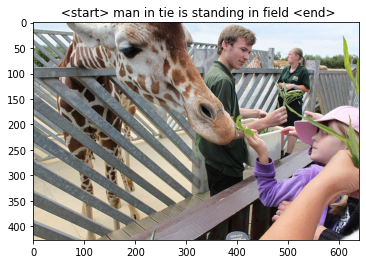

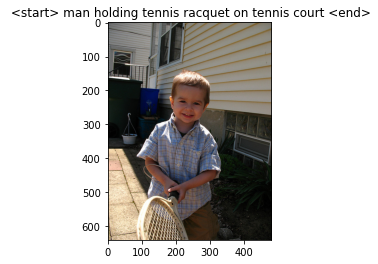

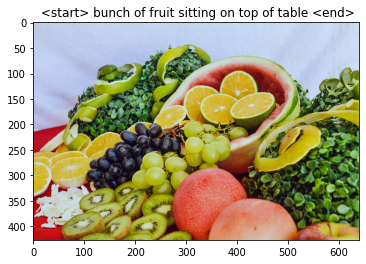

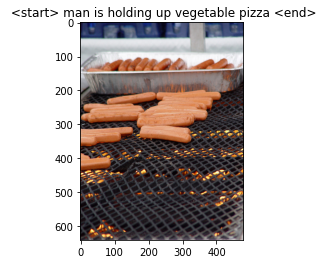

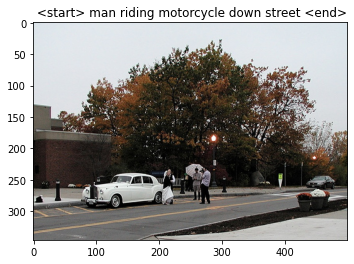

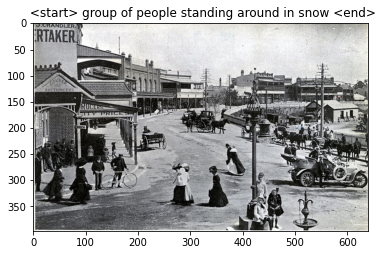

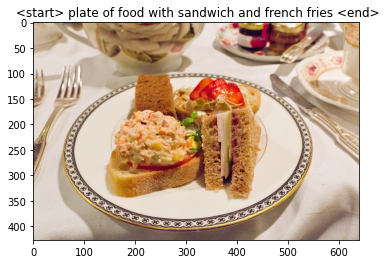

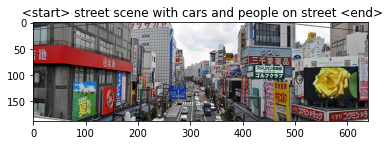

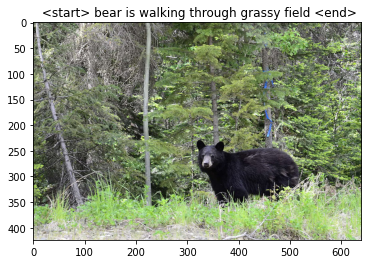

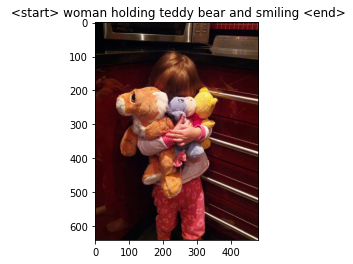

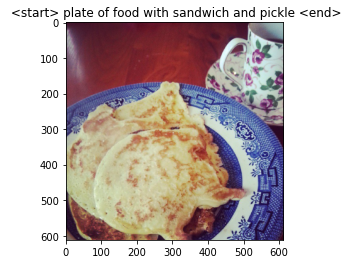

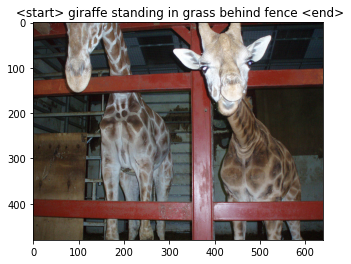

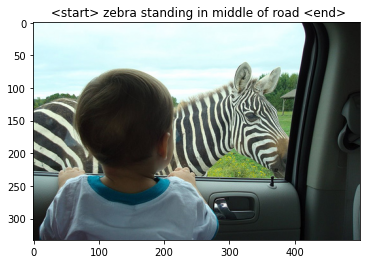

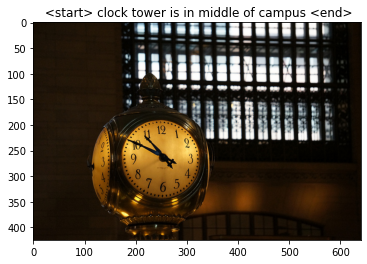

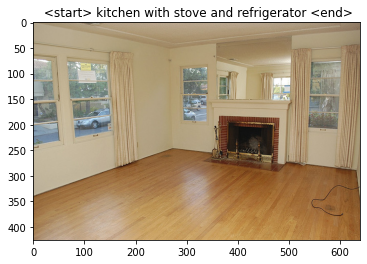

In [ ]:
for i in range(15):
  N = np.random.randint(0, len(img_name_vector))
  plt.figure()
  plt.title(generate_caption(img_name_vector[N], selection='greedy'))
  plt.imshow(load_img(img_name_vector[N]))